In [1]:
import mastermat

First, you would make the master matrix by making a meta-manager which knows about the location of each PSF, and then using these locations in combination with the PSFs to do a singular value decomposition thereof. Normalizing the results of the singular value decomposition, you would get a matrix of kernels and a matrix of weights, which, when multiplied together, should give a matrix whose columns can be shifted up and down to make the final mastermat.

This is intended to be run once,

In [2]:
# row_inds_csr, col_inds_csr, values_csr, row_inds, col_inds, values = mastermat.load_memmaps((800,1280))

In [3]:
# row_ins_csr, col_inds_csr, values_csr = mastermat.compute_csr(row_inds, col_inds, values)

In [4]:
# import numpy as np
# np.save("row_inds_csr.npy", row_inds_csr)
# np.save("col_inds_csr.npy", col_inds_csr)
# np.save("values_csr.npy", values_csr) 

In [5]:
# row_inds_csr, col_inds_csr, values_csr = mastermat.load_csr_files()
# savepath = ("row_inds_lin_csr.npy", "col_inds_lin_csr.npy", "values_lin_csr.npy")
savepath = ("row_inds_lin_circ_csr.npy", "col_inds_lin_circ_csr.npy", "values_lin_circ_csr.npy")
row_inds_csr, col_inds_csr, values_csr = mastermat.load_csr_files(csr_paths=savepath)

In [6]:
values_csr.shape

(29804775,)

In [7]:
row_inds_csr.shape

(1024001,)

In [8]:
import numpy as np

row_inds_csr_expanded = np.empty(1024001)
row_inds_csr_expanded[:row_inds_csr.shape[0]] = row_inds_csr
row_inds_csr_expanded[row_inds_csr.shape[0]:] = row_inds_csr[-1]

In [9]:
import scipy
mastermat_csr = scipy.sparse.csr_matrix((values_csr, col_inds_csr, row_inds_csr_expanded), shape=(1024000, 1024000))

In [10]:
mastermat_csr.shape

(1024000, 1024000)

In [11]:
np.max(mastermat_csr.data)

0.16259367271440284

In [12]:
mastermat_csr.getnnz()

29804775

We're now trying to test this mastermat. To do this, make an appropriately-sized vector of ones, then matrix-multiply it with mastermat

In [13]:
onesvec = np.ones(mastermat_csr.shape[1])

In [14]:
ones_sim = mastermat_csr.dot(onesvec)

In [15]:
mastermat_csr.indptr[83]

1

In [16]:
np.bincount(mastermat_csr.indptr)

array([   1, 1425,    0, ...,    0,    1,    1])

In [17]:
np.arange(mastermat_csr.shape[0])[ones_sim > 0]

array([   1425,    1426,    1427, ..., 1023997, 1023998, 1023999])

In [18]:
ones_sim.reshape((800,1280))

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00849768, 0.0042278 ,
        0.00292282],
       [0.        , 0.        , 0.        , ..., 0.00628084, 0.00247671,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00187902, 0.00399993,
        0.00101888]])

In [19]:
big_inds = np.arange(ones_sim.shape[0])[ones_sim > 10]

In [20]:
import imageio
import cv2

In [21]:
img_resized = imageio.imread("../data/nV3_resized/1.png")

/tmp/ipykernel_575577/2906533047.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_resized = imageio.imread("../data/nV3_resized/1.png")


In [22]:
img_resized.shape

(800, 1280)

In [23]:
mastermat_csr.shape

(1024000, 1024000)

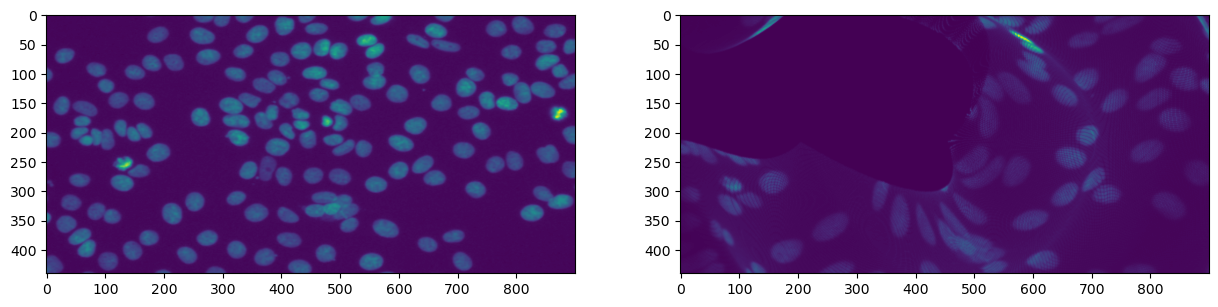

In [24]:
from matplotlib import pyplot as plt
import pdb
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(img_resized[200:640,200:1100])
axs[1].imshow(mastermat.simulate_image(img_resized, mastermat_csr)[200:640,200:1100])

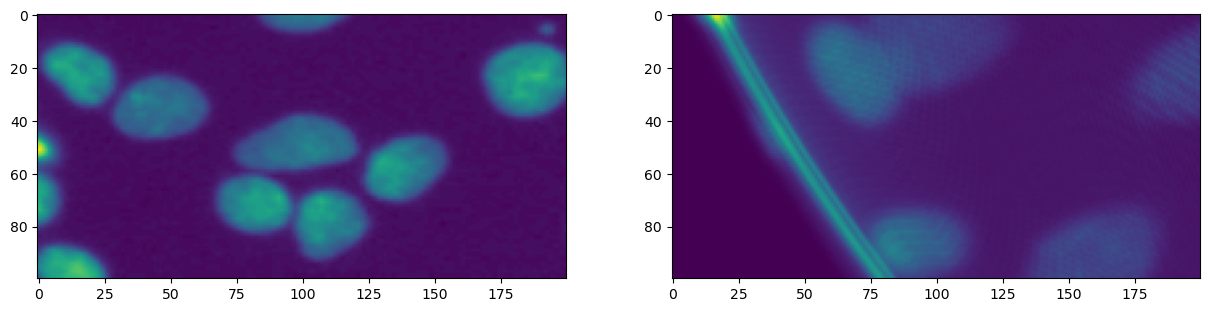

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(img_resized[700:,:200])
axs[1].imshow(mastermat.simulate_image(img_resized, mastermat_csr)[700:,:200])

In [26]:
%time
simmed_img = mastermat.simulate_image(img_resized, mastermat_csr)
# simmed_img[simmed_img > 50] = 0

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 10.3 µs


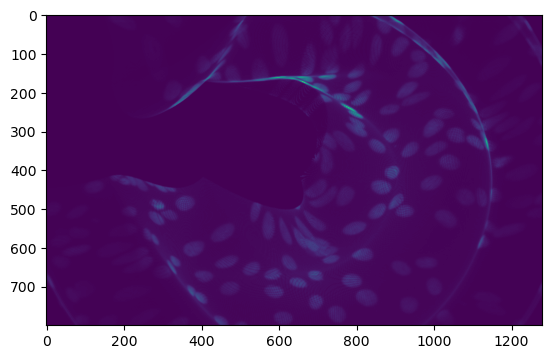

In [27]:
plt.imshow(simmed_img)

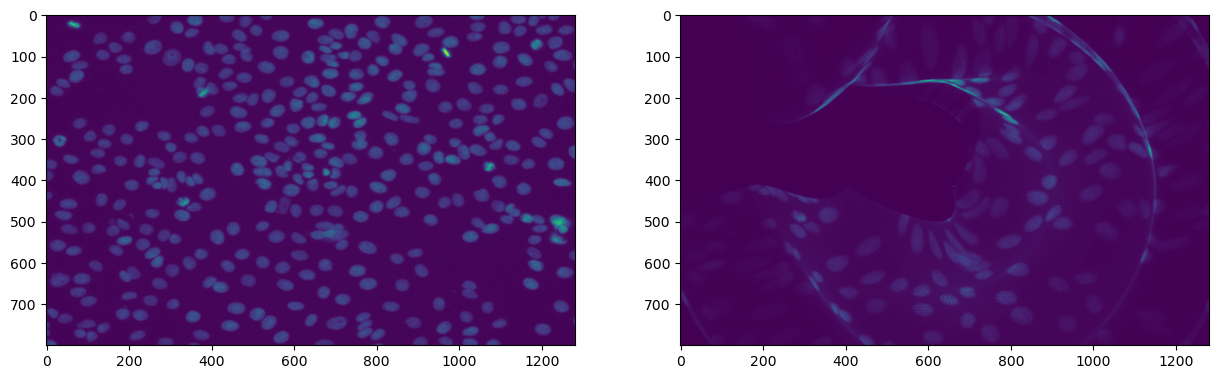

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(img_resized)
axs[1].imshow(simmed_img)

In [29]:
np.arange(ones_sim.shape[0])[ones_sim > 10]

array([], dtype=int64)

In [30]:
ones_sim

array([0.        , 0.        , 0.        , ..., 0.00187902, 0.00399993,
       0.00101888])

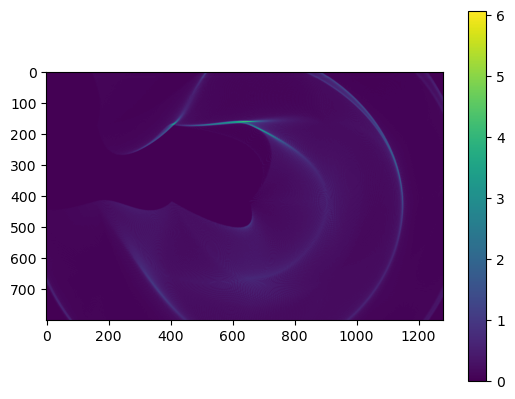

In [31]:
plt.imshow(mastermat.simulate_image(np.ones((800,1280)), mastermat_csr))
plt.colorbar()

In [32]:
mastermat_csr.indptr[200*1280 + 200 + 1] - mastermat_csr.indptr[200*1280 + 200]

17

Above shows that 47 pixels contribute to the value of the simulated image at pixel 40000, but in reality the value at that point is:

In [33]:
ones_sim[200*1280 + 200]

0.06681154038712464

In [34]:
ones_sim[ones_sim > 0].shape

(831697,)

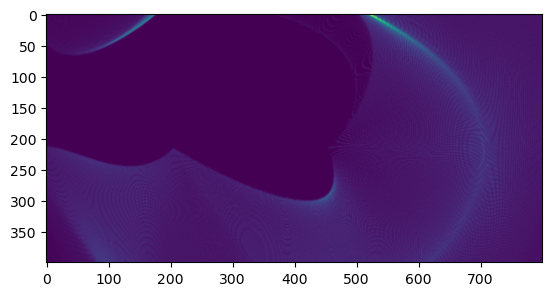

In [35]:
plt.imshow((ones_sim).reshape((800,1280))[200:600, 200:1000])

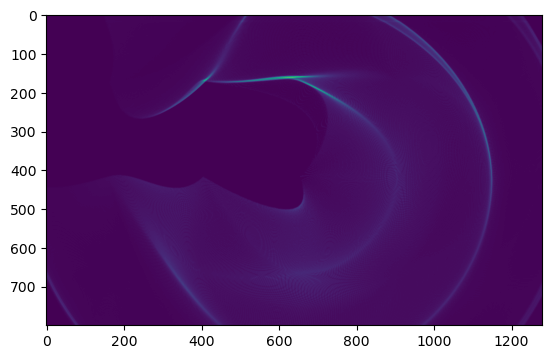

In [36]:
# plt.imshow((ones_sim*(ones_sim < 1)).reshape((800,1280)))
plt.imshow((ones_sim).reshape((800,1280)))

In [37]:
def draw_circle(radius):
    canvas = np.zeros((2*radius, 2*radius))
    Xq, Yq = np.meshgrid(np.arange(radius*2), np.arange(radius*2))
    rad_to_point = (Xq - radius)**2 + (Yq - radius)**2
    canvas = rad_to_point < radius
    return canvas

In [38]:
circle_obj = np.zeros((800, 1280))
r = 10

pdb.set_trace()

for circ_row in range(1,10):
    for circ_col in range(1,10):
        circ_center = (circ_row*80, circ_col*128)
        circle_obj[circ_center[0]-r:circ_center[0]+r, circ_center[1]-r:circ_center[1]+r] = draw_circle(r)[:,:]

--Return--
None
> /tmp/ipykernel_575577/2155879916.py(4)<cell line: 4>()
      2 r = 10
      3 
----> 4 pdb.set_trace()
      5 
      6 for circ_row in range(1,10):

ipdb> c


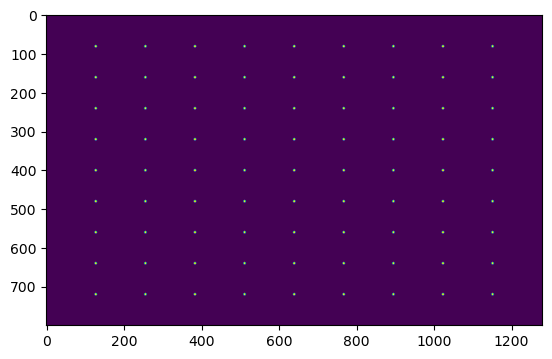

In [39]:
plt.imshow(circle_obj)

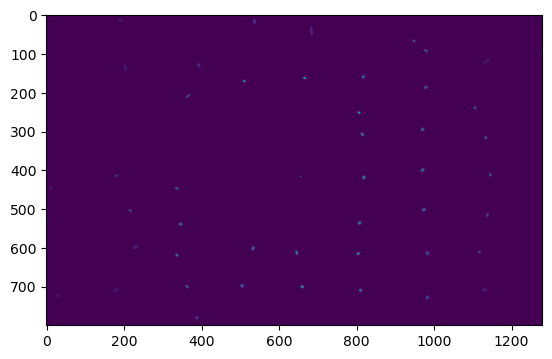

In [40]:
plt.imshow(mastermat.simulate_image(circle_obj, mastermat_csr))

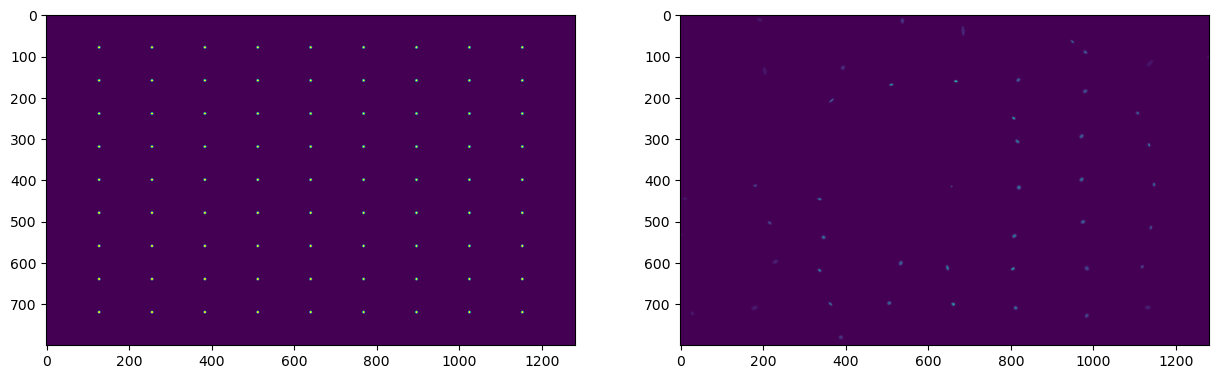

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(circle_obj)
axs[1].imshow(mastermat.simulate_image(circle_obj, mastermat_csr))

In [42]:
big_circle_obj = np.zeros((800, 1280))
r = 20

# pdb.set_trace()

for circ_row in range(1,10):
    for circ_col in range(1,10):
        circ_center = (circ_row*80, circ_col*128)
        big_circle_obj[circ_center[0]-r:circ_center[0]+r, circ_center[1]-r:circ_center[1]+r] = draw_circle(r)[:,:]

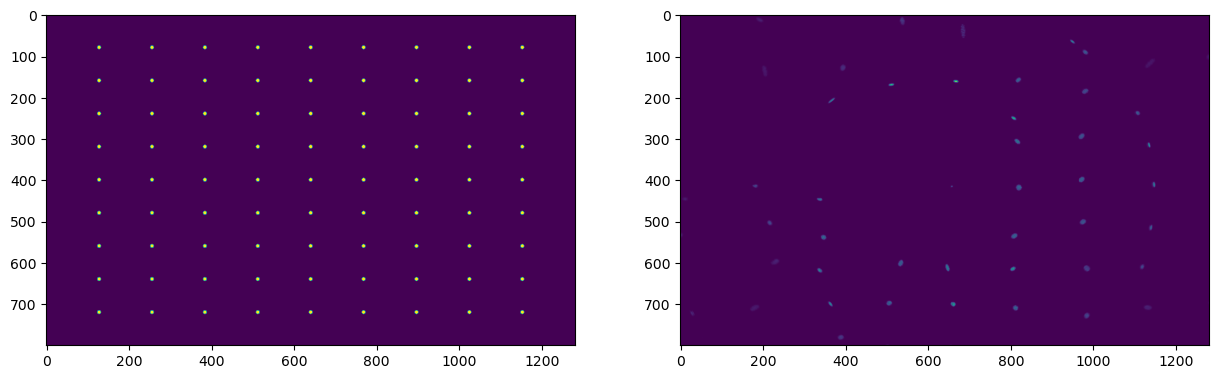

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(big_circle_obj)
axs[1].imshow(mastermat.simulate_image(big_circle_obj, mastermat_csr))

In [44]:
values_csr

array([0.        , 0.00108773, 0.00108643, ..., 0.00111835, 0.00165931,
       0.00101888])

In [45]:
simmed_ones = mastermat.simulate_image(np.ones((800,1280)), mastermat_csr)

In [46]:
np.arange(800*1280).reshape((800, 1280))[simmed_ones > 0]

array([   1425,    1426,    1427, ..., 1023997, 1023998, 1023999])

In [47]:
bc = np.bincount(col_inds_csr)
np.arange(bc.shape[0])[bc == 0].shape

(433163,)

In [48]:
NNZ = values[values!=0].shape[0] 
ri_delta = np.bincount(row_inds[:NNZ].astype(np.int64))

NameError: name 'values' is not defined

In [ ]:
np.arange(ri_delta.shape[0])[ri_delta!=0].shape

In [ ]:
np.any(values_csr < 0)

It seems that the vast majority of rows have at least one nonzero value, and majority of columns have nonzero values as well. Respectively, these facts imply that almost all points on the image have something mapping to them, and almost all points on the object map to something. Also, none of the values are negative.

However, I'm still getting the image above with only four points. The only reason that I could think of is that those four points are much brighter than the rest of the image.

A way to test this hypothesis is to make a plot of a Boolean selector matrix, which I'll do below.

In [ ]:
plt.imshow(simmed_img > 0)

Yes, hypothesis confirmed.

In [ ]:
csr_from_coo = scipy.sparse.csr_matrix((values[:NNZ], (row_inds[:NNZ], col_inds[:NNZ])), shape=(800*1280, 800*1280))

In [ ]:
csr_from_coo.indptr.shape

In [ ]:
mastermat_csr.indptr.shape

In [ ]:
plt.imshow(mastermat.simulate_image(np.ones((800,1280)), csr_from_coo))

In [ ]:
np.arange(800*1280)[np.ravel(simmed_img) > 200]

In [ ]:
import one_shot_svd
pdb.set_trace()
metaman = one_shot_svd.load_metaman("/home/dshteinbok/nV3_PSFs_flat_meta/metafile.csv")
kermat, weightsmat = one_shot_svd.generate_unpadded("/home/dshteinbok/nV3_PSFs_flat", metaman, (800,1280), (640, 1024))

In [ ]:
kermat.shape

In [ ]:
kernels_as_rows = kermat.transpose((2,0,1)).reshape((28,1024))

In [ ]:
np.linalg.norm(kernels_as_rows, axis=1)

In [ ]:
plt.imshow(np.sum(weightsmat, -1))